In [1]:
import numpy as np
import pandas as pd
import os
import torch
from utils.csv_to_pd import *
from utils.lstm_tool import *

In [7]:

def get_full_9_17(df):
    location = df["LocationCode"].unique()
    used_train_data = []
    for l in location:
        l_df = df[df["LocationCode"] == l]
        month_day = l_df["month_day"].unique()
        for md in month_day:
            l_md_df = l_df[l_df["month_day"] == md]
            if len(l_md_df) == 48:
                used_train_data.append((int(l), int(md), np.array(l_md_df['Power(mW)'])))
    return used_train_data

def get_data_label(df, target_data: tuple):
    location, month_day, label_np = target_data

    target_df = df[df["LocationCode"] == location].copy()
    target_df = target_df[target_df["month_day"] == month_day]

    if len(target_df) == 0:
        return None


    target_df = target_df.drop(columns=['month_day'])
    target_df["LocationCode"] = target_df["LocationCode"] / 17
    

    data = np.array(target_df)
    label = label_np

    
    return len(data), data, label
def get_data_label_list(feature_df, target_datas):
    data_label_list = []

    for target_data in target_datas:
        data_label = get_data_label(feature_df, target_data)
        if data_label != None:
            data_label_list.append(data_label)
    return data_label_list

def get_upload_data_list(feature_df, target_datas):
    data_list = []

    for target_data in target_datas:
        data_label = get_data_label(feature_df, target_data)
        
        if data_label != None:
            _, data, _ = data_label
            data_list.append(torch.from_numpy(np.array(data)))
    return data_list


def get_batch(data, label, batch_size=64):
    batch_datas = []
    batch_labels = []

    for i in range(0, len(data), batch_size):
        this_batch_length = len(data[i])
        batch_data = []
        for j in range(i, min(i + batch_size, len(data))):
            batch_data.append(data[j][-this_batch_length:len(data[j])])
        
        batch_datas.append(torch.from_numpy(np.array(batch_data)))
        batch_labels.append(torch.from_numpy(np.array(label[i:i + batch_size])))
    return batch_datas, batch_labels



In [8]:
import category_encoders as ce

target_df = read_dir_csv()
target_df['DateTime'] = pd.to_datetime(target_df['DateTime'])
target_df["month_day"] = target_df['DateTime'].dt.month * 100 + target_df['DateTime'].dt.day
target_df['hour'] = target_df['DateTime'].dt.hour

location_ori = list(target_df["LocationCode"]) 


In [9]:
after_9 = target_df[target_df['DateTime'].dt.hour >= 9].drop(columns=["WindSpeed(m/s)", "Pressure(hpa)", "Temperature(°C)", "Humidity(%)", "Sunlight(Lux)"])
between_9_17 = after_9[after_9['DateTime'].dt.hour < 17]
mean_10_between_9_17 = mean_10min(between_9_17)

c:\Users\weiso131\Desktop\power_generation_predict\utils\csv_to_pd.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DateTime'] = pd.to_datetime(df['DateTime'])


In [10]:
upload = pd.read_csv(f"36_TestSet_SubmissionTemplate/upload(no answer).csv")


upload_target_set = set()
upload_target_list = []
for u_target in list(upload['序號']):
    month_day = int((u_target % 1e10) / 1e6)
    location = int(u_target % 100)
    if not month_day * 100 + location in upload_target_set:
        upload_target_set.add(month_day * 100 + location)
        upload_target_list.append((location, month_day, np.array(list(range(48)))))

print(len(upload_target_list))




200


In [11]:
from sklearn.preprocessing import StandardScaler

target_datas = get_full_9_17(mean_10_between_9_17)
len(target_datas)

columns_to_standardize = ['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)', "hour", "Power(mW)"]
scaler = StandardScaler()
target_df[columns_to_standardize] = scaler.fit_transform(target_df[columns_to_standardize])


feature_df = target_df[target_df['DateTime'].dt.hour < 9]
feature_df = feature_df.drop(columns=['DateTime'])



data_label_list = get_data_label_list(feature_df, target_datas)
train_data_label_list, valid_data_label_list = split_data_random(data_label_list,train_ratio=0.9)
train_data, train_label, train_length = sort_by_length(train_data_label_list)
valid_data, valid_label, valid_length = sort_by_length(valid_data_label_list)



upload_data_batch = get_upload_data_list(feature_df, upload_target_list)

print(upload_data_batch[0].shape)



torch.Size([154, 8])


In [12]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import torch.nn as nn

class LSTMTagger(nn.Module):

    def __init__(self, hidden_dim, tagset_size=48, input_dim=8):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        # LSTM層
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # 線性層
        self.linear = nn.Linear(hidden_dim, tagset_size)
        self.relu = nn.ReLU()

    def init_hidden(self, batch_size):
        # 初始化隱藏狀態和細胞狀態
        return (torch.zeros(1, batch_size, self.hidden_dim),
                torch.zeros(1, batch_size, self.hidden_dim))

    def forward(self, sentence, hidden):
        """
        sentence: Tensor, shape (batch_size, seq_len, input_dim)
        hidden: Initial hidden state

        Returns:
            tag_space: Tensor, shape (batch_size, tagset_size)
            hidden: Final hidden state
        """
        # LSTM層
        lstm_out, hidden = self.lstm(sentence, hidden)

        # 取最後一個時間步的輸出
        last_output = lstm_out[:, -1, :]  # shape: (batch_size, hidden_dim)

        # 線性層和激活函數
        tag_space = self.relu(self.linear(self.relu(last_output)))

        return tag_space, hidden


In [13]:
import torch.optim as optim

# 設置 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定義訓練函數
def train_model(model, train_loader, valid_loader, train_length, valid_length, num_epochs=10, learning_rate=0.001):
    # 將模型移到 GPU
    model = model.to(device, dtype=torch.float32)
    # 使用 Adam 優化器
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # 定義損失函數
    criterion = nn.SmoothL1Loss()
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for inputs, labels in train_loader:
            # 將輸入和標籤移到 GPU
            inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
            
            # 初始化隱藏狀態
            hidden = model.init_hidden(batch_size=inputs.size(0))
            hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])

            

            # 清零梯度
            optimizer.zero_grad()
            # 前向傳播
            outputs, _ = model(inputs, hidden)

            
            # 計算損失
            loss = criterion(outputs.squeeze(), labels)
            # 反向傳播
            loss.backward()
            # 更新參數
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_loss / train_length:.4f}")

        # 驗證模型
        validate_model(model, valid_loader, criterion, valid_length)

# 定義驗證函數
def validate_model(model, valid_loader, criterion, valid_length):
    model.eval()
    total_loss = 0.0
    error = 0
    count = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            # 將輸入和標籤移到 GPU
            inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
            
            # 初始化隱藏狀態
            hidden = model.init_hidden(batch_size=inputs.size(0))
            hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])

            # 前向傳播
            outputs, _ = model(inputs, hidden)
            # 計算損失
            loss = criterion(outputs.squeeze(), labels.squeeze())
            error += abs(outputs.view(-1) - labels.view(-1)).sum()
            count += labels.shape[0] * labels.shape[1]
            total_loss += loss.item()

    print(f"Validation Loss: {total_loss / valid_length:.4f}, valid error: {error / count}, count: {count}")
    return total_loss


In [14]:
batch = 32

batch_train_data, batch_train_label = get_batch(train_data, train_label, batch)
batch_valid_data, batch_valid_label = get_batch(valid_data, valid_label, batch)
train_loader = list(zip(batch_train_data, batch_train_label))
valid_loader = list(zip(batch_valid_data, batch_valid_label))



In [15]:
model = LSTMTagger(256, 48, input_dim=8)
train_length, valid_length = len(batch_train_data), len(batch_valid_data)
train_model(model, train_loader, valid_loader, train_length, valid_length, 600)


Epoch [1/600], Training Loss: 371.0839
Validation Loss: 373.2676, valid error: 366.0852355957031, count: 7440
Epoch [2/600], Training Loss: 367.2576
Validation Loss: 370.4843, valid error: 363.34197998046875, count: 7440
Epoch [3/600], Training Loss: 364.7589
Validation Loss: 368.5193, valid error: 361.4134216308594, count: 7440
Epoch [4/600], Training Loss: 362.8750
Validation Loss: 366.9583, valid error: 359.8894348144531, count: 7440
Epoch [5/600], Training Loss: 361.3131
Validation Loss: 365.6217, valid error: 358.5890808105469, count: 7440
Epoch [6/600], Training Loss: 359.9703
Validation Loss: 364.4360, valid error: 357.438232421875, count: 7440
Epoch [7/600], Training Loss: 358.7978
Validation Loss: 363.3889, valid error: 356.4252624511719, count: 7440
Epoch [8/600], Training Loss: 357.7488
Validation Loss: 362.4577, valid error: 355.52789306640625, count: 7440
Epoch [9/600], Training Loss: 356.7585
Validation Loss: 361.6055, valid error: 354.70965576171875, count: 7440
Epoch [1

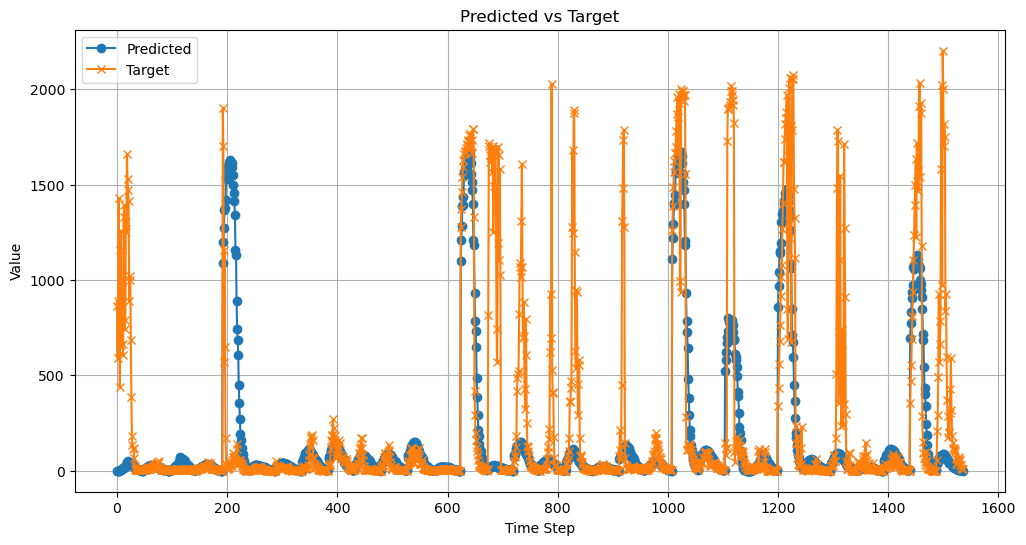

In [19]:
inputs, labels = valid_loader[0]
model = model.to('cuda', dtype=torch.float32)
hidden = model.init_hidden(32)
hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])

inputs, labels = inputs.to('cuda', dtype=torch.float32), labels.to('cuda', dtype=torch.float32)

predicted, _ = model(inputs, hidden)
predicted = predicted.detach().to('cpu').numpy()
target = labels.to('cpu').numpy()


predicted_plot = predicted.reshape(-1)
target_plot = target.reshape(-1)

# 繪製折線圖
plt.figure(figsize=(12, 6))
plt.plot(predicted_plot, label='Predicted', marker='o')
plt.plot(target_plot, label='Target', marker='x')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Predicted vs Target')
plt.legend()
plt.grid()
plt.show()


In [21]:
model.eval()

ans = []

with torch.no_grad():
    for inputs in upload_data_batch:
        # 將輸入和標籤移到 GPU
        inputs = inputs.to(device, dtype=torch.float32)
        inputs = inputs.view(1, -1, 8)
        # 初始化隱藏狀態
        hidden = model.init_hidden(batch_size=inputs.size(0))
        hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])

        # 前向傳播
        outputs, _ = model(inputs, hidden)

        outputs = outputs.to('cpu', dtype=torch.float32)
        ans.extend(outputs.view(-1).tolist())


upload['答案'] = np.array(ans)
        

In [22]:
upload

,序號,答案
0,20240117090001,143.473816
1,20240117091001,160.068924
2,20240117092001,165.840820
3,20240117093001,175.341751
4,20240117094001,202.433640
...,...,...
9595,20241002161012,5.341837
9596,20241002162012,4.166429
9597,20241002163012,3.528496
9598,20241002164012,2.473240


In [24]:
upload.to_csv('try.csv', index=False)